# Backblaze SSDs vs HDDs Endurance

Backblaze stated in [this](https://www.backblaze.com/blog/are-ssds-really-more-reliable-than-hard-drives/) article that SSDs seem
to fail at quicker rate than HDDs when it comes to raw power on hours. SSD lives however are typically measured in terabytes written (TBW),
not in power on hours; Unlike HDDs where there are moving parts that wear down with use, SSDs memory cells ware down over time
with the number of writes that are performed. In this analysis, we put to the test if the SSDs in Backblaze's study likely failed
due to power on hours, or if they failed due to too many write cycles.

In the `data_downloader.py` we downloaded all the data from Backblaze and stripped the data down to just the columns we need
for this analysis. The remaining columns are:
* date
* serial_number
* model
* capacity_bytes
* failure
* Smart 9: Power-on Hours (raw/normalized)
* Smart 241: Total LBAs Written (raw/normalized)
* Smart 242: Total LBAs Read (raw/normalized)

Backblaze only looked at boot drives, not storage drives. Thus, since they don't define which drives are boot drives vs
storage drives, so we use the heuristic of drives that are below 2TB as storage drives normally start around 3TB. We can
see that of the drives that are below 2TB, the max is ~1TB so we can be reasonably assured that our heuristic is okay.


Below we parse through the data we downloaded earlier. We keep track of number of failed drives and their serial
numbers in `year_drives_hdds` and `year_drives_ssds` respectively. We also keep track of the row of smart data for each
failed drive in `failed_drives` so we can analyze the data later. We then also keep track of the power on hours for
each drive in the year in `power_on_hours_years_hdd` and `power_on_hours_years_ssd` respectively; We also keep track
of the power on hours irrespective of drive type in `power_on_hours_years`. We use this data for keeping track of the
start power on hours for the year and the end power on hours for the year, so we can then deduce how many hours were
racked up in the year. This then give us the "drive days" or the number of effective days that the drive was on for.

We also mark if a drive is an SSD or not based on if the drive model is in our list of SSD models. This was collected
from the data in this processing step.

In [ ]:
import glob
import lzma
import pickle
import pandas as pd
import numpy as np
import os
from datetime import datetime

failed_drives = {"ssd": [], "hdd": []}

# year > {"all_drives": set(), "failed_drives": 0}
year_drives_hdds = {}

year_drives_ssds = {}

ssd_models = set()

power_on_hours_years = {}

power_on_hours_years_hdd = {}
power_on_hours_years_ssd = {}

for file in sorted(glob.glob("./data/*.xz")):
    print(f"Loading: {file}")
    with lzma.open(file, "rb") as f:
        dfs = pickle.load(f)

        for dict_vals in sorted(dfs, key=lambda x: x["filename"]): # todo sort by date
            filename = dict_vals["filename"]
            date_df = pd.DataFrame.from_dict(dict_vals["data"])

            date_df["isSSD"] = date_df["model"].map(lambda x: 1 if x in ssd_endurance.keys() else 0)

            # only get the boot hard drives
            boot_hdd = date_df[(date_df["capacity_bytes"] <= 2250059350016) & (date_df["isSSD"] == 0)]
            boot_ssd = date_df[date_df["isSSD"] == 1]

            date_df = pd.concat([boot_hdd, boot_ssd])

            unique_serial_numbers_hdds = date_df["serial_number"][pd.isna(date_df["smart_173_raw"])].unique().tolist()
            unique_serial_numbers_ssds = date_df["serial_number"][~pd.isna(date_df["smart_173_raw"])].unique().tolist()
            ssd_models.update(date_df["model"][~pd.isna(date_df["smart_173_raw"])].unique().tolist())

            year = os.path.basename(filename)[:4]
            datetime = datetime.strptime(os.path.basename(filename)[:-4], '%Y-%m-%d')
            if year not in year_drives_hdds.keys():
                year_drives_ssds[year] = {"all_drives": set(unique_serial_numbers_ssds), "failed_drives": 0}
                year_drives_hdds[year] = {"all_drives": set(unique_serial_numbers_hdds), "failed_drives": 0}
                power_on_hours_years[year] = {}
                power_on_hours_years_ssd[year] = {}
                power_on_hours_years_hdd[year] = {}
            else:
                year_drives_ssds[year]["all_drives"].update(unique_serial_numbers_ssds)
                year_drives_hdds[year]["all_drives"].update(unique_serial_numbers_hdds)

            for index, item in date_df.iterrows():
                if power_on_hours_years[year].get(item["serial_number"], -1) != -1:
                    if datetime > power_on_hours_years[year][item["serial_number"]]["datetimeEnd"]:
                        power_on_hours_years[year][item["serial_number"]]["datetimeEnd"] = datetime
                        power_on_hours_years[year][item["serial_number"]]["powerOnHoursEnd"] = item["smart_9_raw"]
                        if item["isSSD"] == 1:
                            power_on_hours_years_ssd[year][item["serial_number"]]["datetimeEnd"] = datetime
                            power_on_hours_years_ssd[year][item["serial_number"]]["powerOnHoursEnd"] = item["smart_9_raw"]
                        else:
                            power_on_hours_years_hdd[year][item["serial_number"]]["datetimeEnd"] = datetime
                            power_on_hours_years_hdd[year][item["serial_number"]]["powerOnHoursEnd"] = item["smart_9_raw"]

                    elif datetime < power_on_hours_years[year][item["serial_number"]]["datetimeStart"]:
                        power_on_hours_years[year][item["serial_number"]]["datetimeStart"] = datetime
                        power_on_hours_years[year][item["serial_number"]]["powerOnHoursStart"] = item["smart_9_raw"]
                        if item["isSSD"] == 1:
                            power_on_hours_years_ssd[year][item["serial_number"]]["datetimeStart"] = datetime
                            power_on_hours_years_ssd[year][item["serial_number"]]["powerOnHoursStart"] = item["smart_9_raw"]
                        else:
                            power_on_hours_years_hdd[year][item["serial_number"]]["datetimeStart"] = datetime
                            power_on_hours_years_hdd[year][item["serial_number"]]["powerOnHoursStart"] = item["smart_9_raw"]
                else:
                    power_on_hours_years[year][item["serial_number"]] = {"datetimeStart": datetime, "powerOnHoursStart": item["smart_9_raw"],
                                                                         "datetimeEnd": datetime, "powerOnHoursEnd": item["smart_9_raw"]}

                    if item["isSSD"] == 1:
                        power_on_hours_years_ssd[year][item["serial_number"]] = {"datetimeStart": datetime, "powerOnHoursStart": item["smart_9_raw"],
                                                                                 "datetimeEnd": datetime, "powerOnHoursEnd": item["smart_9_raw"]}
                    else:
                        power_on_hours_years_hdd[year][item["serial_number"]] = {"datetimeStart": datetime, "powerOnHoursStart": item["smart_9_raw"],
                                                                                 "datetimeEnd": datetime, "powerOnHoursEnd": item["smart_9_raw"]}

            failed = date_df.loc[date_df['failure'] == 1]

            year_drives_hdds[year]["failed_drives"] += len(failed[failed["isSSD"] == 0])
            year_drives_ssds[year]["failed_drives"] += len(failed[failed["isSSD"] == 1])

            for index, item in failed.iterrows():
                if item["isSSD"] == 1:
                    failed_drives["ssd"].append(item.to_dict())
                else:
                    failed_drives["hdd"].append(item.to_dict())
del dfs
del f

![Backblaze Stats](./imgs/image1-2.webp)

We can see that from 4/2013 to 6/2021, Backblaze has a HDD count of 1607, 619 HDD failures, and a SSD count of 1666, 17 SSD drive failures.
We can see that we got a different drive count, 1909 HDDs, 2061 HDD failures and 1100 SSDs and 14 SSD failures. It is hard to
say what caused this exactly but they're within the same ballpark so we continue with our analysis.

In [49]:
print(f"Total HDDs: {len(unique_serial_numbers_hdds)}")
print(f"Total SSDs: {len(unique_serial_numbers_ssds)}")

print()

print(f"Total Failed SSDs: {len(failed_drives['ssd'])}")
print(f"Total Failed HDDs: {len(failed_drives['hdd'])}")

print()

Total HDDs: 1909
Total SSDs: 1100

Total Failed SSDs: 14
Total Failed HDDs: 2061
HDD Failure rate 2013: 0.03681117640536645
HDD Failure rate 2014: 0.04558434690639873
HDD Failure rate 2015: 0.04809619238476954
HDD Failure rate 2016: 0.02808594298553574
HDD Failure rate 2017: 0.008665511265164644
HDD Failure rate 2018: 0.04164170161773517
HDD Failure rate 2019: 0.026352874859075535
HDD Failure rate 2020: 0.0091952880361847
HDD Failure rate 2021: 0.0052056220718375845

SSD Failure rate 2018: 0.0
SSD Failure rate 2019: 0.0034965034965034965
SSD Failure rate 2020: 0.005439709882139619
SSD Failure rate 2021: 0.004824259131633356


Below we can see the rate of drive failures in each year.

In [ ]:
hdd_failure_rates = []
for key in year_drives_hdds.keys():
    if len(year_drives_hdds[key]['all_drives']) > 0:
        failure_rate = year_drives_hdds[key]['failed_drives'] / len(year_drives_hdds[key]['all_drives'])
        hdd_failure_rates.append(failure_rate)
        print(f"HDD Failure rate {key}: {failure_rate}")

print()
ssd_failure_rates = []
for key in year_drives_ssds.keys():
    if len(year_drives_ssds[key]['all_drives']) > 0:
        failure_rate = year_drives_ssds[key]['failed_drives'] / len(year_drives_ssds[key]['all_drives'])
        ssd_failure_rates.append(failure_rate)
        print(f"SSD Failure rate {key}: {year_drives_ssds[key]['failed_drives'] / len(year_drives_ssds[key]['all_drives'])}")

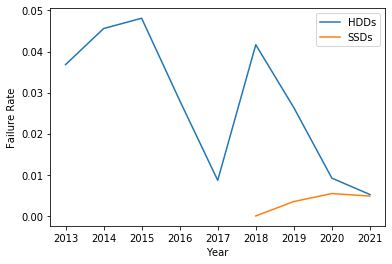

In [50]:
import matplotlib.pyplot as plt
plt.plot(list(year_drives_hdds.keys()), hdd_failure_rates, label="HDDs")
plt.plot(["2018", "2019", "2020", "2021"], ssd_failure_rates, label="SSDs")
plt.ylabel('Failure Rate')
plt.xlabel('Year')
plt.legend()

Next, we compute the annualized failure rate (AFR) based on [this](https://www.backblaze.com/blog/hard-drive-reliability-q4-2015/) article
from Backblaze to ensure we are using the same AFR metric as their analysis.

In [51]:
def get_afr(year_hours, year_drives_failed, dict_to_populate):
    for year in year_hours.keys():
        if year_hours[year] > 0:
            afr_ = afr(year_drives_failed[year], year_hours[year])
            dict_to_populate[year] = afr_
            print(f"AFR {year}: {afr_}")

def get_year_hours(power_on_hours):
    year_hours = {}
    for year in power_on_hours.keys():
        year_hours[year] = 0
        for drive in power_on_hours[year].keys():
            if not pd.isna(power_on_hours[year][drive]["powerOnHoursEnd"]) and not pd.isna(power_on_hours[year][drive]["powerOnHoursStart"]):
                year_hours[year] += power_on_hours[year][drive]["powerOnHoursEnd"] - power_on_hours[year][drive]["powerOnHoursStart"]

    return year_hours

# get the drive hours in each year (end of the year power on hours - start of the year power on hours)
year_hours_all = get_year_hours(power_on_hours_years)
year_hours_ssd = get_year_hours(power_on_hours_years_ssd)
year_hours_hdd = get_year_hours(power_on_hours_years_hdd)

# annualized failure rate

year_drives_failed_all = {}
year_drives_failed_hdd = {}
for key in year_drives_hdds.keys():
    year_drives_failed_hdd[key] = year_drives_hdds[key]['failed_drives']
    year_drives_failed_all[key] = year_drives_hdds[key]['failed_drives']

year_drives_failed_ssd = {}
for key in year_drives_ssds.keys():
    year_drives_failed_ssd[key] = year_drives_ssds[key]['failed_drives']
    year_drives_failed_all[key] += year_drives_ssds[key]['failed_drives']

def afr(num_failed_drives, total_drive_hours):
    return (100*num_failed_drives)/(total_drive_hours/24/365)

afr_ssd = {}
print("AFR SSD")
get_afr(year_hours_ssd, year_drives_failed_ssd, afr_ssd)

print()
afr_hdd = {}
print("AFR HDD")
get_afr(year_hours_hdd, year_drives_failed_hdd, afr_hdd)

print()
afr_all = {}
print("AFR All")
get_afr(year_hours_all, year_drives_failed_all, afr_all)

def process_for_plot(input_):
    years = []
    num = []

    for key in input_.keys():
        years.append(key)
        num.append(input_[key])

    return years, num

print()
print("HDD Cumulative")
cumulative_hdd = {}
curr_faileds = 0
curr_hours = 0
for year in year_hours_hdd.keys():
    if year_hours_hdd[year] > 0:
        curr_faileds += year_drives_failed_hdd[year]
        curr_hours += year_hours_hdd[year]

        afr_ = afr(curr_faileds, curr_hours)
        cumulative_hdd[year] = afr_
        print(f"AFR {year}: {afr_}")

AFR SSD
AFR 2018: 0.0
AFR 2019: 1.2273359664079826
AFR 2020: 0.8819474123753532
AFR 2021: 1.1189705470966709

AFR HDD
AFR 2013: 5.417587241592478
AFR 2014: 5.237883606794699
AFR 2015: 5.982598276616726
AFR 2016: 4.834308891532981
AFR 2017: 2.653846876266712
AFR 2018: 7.868406516501527
AFR 2019: 10.77883696841295
AFR 2020: 10.686792249774193
AFR 2021: 13.262933528010514

AFR All
AFR 2013: 5.417587241592478
AFR 2014: 5.237883606794699
AFR 2015: 5.982598276616726
AFR 2016: 4.834308891532981
AFR 2017: 2.653846876266712
AFR 2018: 7.862429565896566
AFR 2019: 10.350380569179174
AFR 2020: 7.920639468223236
AFR 2021: 8.041490740422542

HDD Cumulative
AFR 2013: 5.417587241592478
AFR 2014: 5.3145904833742605
AFR 2015: 5.538138779275961
AFR 2016: 5.424903663922188
AFR 2017: 5.25348156849409
AFR 2018: 5.41180577163504
AFR 2019: 5.713022478845436
AFR 2020: 5.976789650227349
AFR 2021: 6.157326143003943


In [52]:
# Analyzing full drive hours, not just in that year

def get_year_hours(power_on_hours):
    year_hours = {}
    for year in power_on_hours.keys():
        year_hours[year] = 0
        for drive in power_on_hours[year].keys():
            if not pd.isna(power_on_hours[year][drive]["powerOnHoursEnd"]):
                year_hours[year] += power_on_hours[year][drive]["powerOnHoursEnd"]

    return year_hours

year_hours_all = get_year_hours(power_on_hours_years)
year_hours_ssd = get_year_hours(power_on_hours_years_ssd)
year_hours_hdd = get_year_hours(power_on_hours_years_hdd)

# annualized failure rate

year_drives_failed_all = {}
year_drives_failed_hdd = {}
for key in year_drives_hdds.keys():
    year_drives_failed_hdd[key] = year_drives_hdds[key]['failed_drives']
    year_drives_failed_all[key] = year_drives_hdds[key]['failed_drives']

year_drives_failed_ssd = {}
for key in year_drives_ssds.keys():
    year_drives_failed_ssd[key] = year_drives_ssds[key]['failed_drives']
    year_drives_failed_all[key] += year_drives_ssds[key]['failed_drives']

def afr(num_failed_drives, total_drive_hours):
    return (100*num_failed_drives)/(total_drive_hours/24/365)

afr_ssd = {}
print("AFR SSD")
get_afr(year_hours_ssd, year_drives_failed_ssd, afr_ssd)

print()
afr_hdd = {}
print("AFR HDD")
get_afr(year_hours_hdd, year_drives_failed_hdd, afr_hdd)

print()
afr_all = {}
print("AFR All")
get_afr(year_hours_all, year_drives_failed_all, afr_all)

def process_for_plot(input_):
    years = []
    num = []

    for key in input_.keys():
        years.append(key)
        num.append(input_[key])

    return years, num

print()
print("HDD Cumulative")
cumulative_hdd = {}
curr_faileds = 0
curr_hours = 0
for year in year_hours_hdd.keys():
    if year_hours_hdd[year] > 0:
        curr_faileds += year_drives_failed_hdd[year]
        curr_hours += year_hours_hdd[year]

        afr_ = afr(curr_faileds, curr_hours)
        cumulative_hdd[year] = afr_
        print(f"AFR {year}: {afr_}")


AFR SSD
AFR 2018: 0.0
AFR 2019: 1.153899349943688
AFR 2020: 0.7595815884706614
AFR 2021: 0.48899782797882574

AFR HDD
AFR 2013: 1.155905243511885
AFR 2014: 1.181211428686417
AFR 2015: 1.0762756745765234
AFR 2016: 0.6198070858935665
AFR 2017: 0.68564606400546
AFR 2018: 2.152622459837346
AFR 2019: 3.0780979124208123
AFR 2020: 2.772714362292549
AFR 2021: 1.5830097645056125

AFR All
AFR 2013: 1.155905243511885
AFR 2014: 1.181211428686417
AFR 2015: 1.0762756745765234
AFR 2016: 0.6198070858935665
AFR 2017: 0.68564606400546
AFR 2018: 2.1521524255009172
AFR 2019: 3.0510351997846517
AFR 2020: 2.5596112088317566
AFR 2021: 1.396133457346905

HDD Cumulative
AFR 2013: 1.155905243511885
AFR 2014: 1.1700651972768228
AFR 2015: 1.1343308075258889
AFR 2016: 1.013686132318554
AFR 2017: 0.9987535382606147
AFR 2018: 1.048215562075756
AFR 2019: 1.1269069882634515
AFR 2020: 1.1941172034759076
AFR 2021: 1.20998219021349


![Backblaze Stats](./imgs/image2-1.webp)


We can see in our plot below, that our plot and the plot provided by Backblaze for AFR rates varies substantially.
This is concerning as it means that one of us is doing the analysis incorrectly, or that their statistics are not replicable
based on the information they've provided. We then also plot the cumulative HDD AFR rate in case that is what they used
and that diverges more.

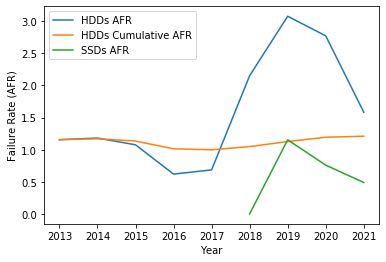

In [53]:
import matplotlib.pyplot as plt
ssd_year, ssd_afr = process_for_plot(afr_ssd)
hdd_year, hdd_afr = process_for_plot(afr_hdd)
hdd_cum_year, hdd_cum_afr = process_for_plot(cumulative_hdd)

plt.plot(hdd_year, hdd_afr, label="HDDs AFR")
plt.plot(hdd_cum_year, hdd_cum_afr, label="HDDs Cumulative AFR")
plt.plot(ssd_year, ssd_afr, label="SSDs AFR")
plt.ylabel('Failure Rate (AFR)')
plt.xlabel('Year')
plt.legend()

We then collect the SSD's manufactures drive lifetimes in terabytes written (TBW) and their mean time between failure rate (MTBF)
so we can compare the times that drives are failing with when we should expect the drives to fail.

In [54]:
ssd_endurance = {'Seagate BarraCuda SSD ZA2000CM10002': (1067, 1800000),
                 'MTFDDAV240TDU': (438, 3000000),
                 'Seagate BarraCuda SSD ZA500CM10002': (249,1800000),
                 'Seagate BarraCuda 120 SSD ZA250CM10003': (150, 1800000),
                 'SSDSCKKB480G8R': (1200, 2000000),
                 'Seagate SSD': (120, 1800000), # ZA250CM10002
                 'Seagate BarraCuda SSD ZA250CM10002': (120, 1800000)}

We can see that the SSDs seem to be failing far, far before we would expect them to. We can also see that the SMART data seems to be
quite junk as some have drive lives over 100%. We can also see that the drives seem to have mere megabytes written to them based on
the reported 241 values. The values here can be multiplied by the flash block size of 512 bytes to give us a figure of total bytes
written. We can also see that almost no data has been read from the drives as the 242 values are also low. This makes me question
if the smart data is accurate at all for these drives as this data is rather nonsensical. While I am not an expert on collecting drive
information, this seems to suggest that Backblaze needs to rethink how they are collecting their data so that their published
information can be independently verified by 3rd parties as currently that seems impossible. There also seems to be
concern about Backblaze's data integrity from other comments as well on the site, so this leads us to question what data
they're using for their analysis and if they're doing their analysis correctly. Overall it seems we can't complete the
set out objective of looking at the TBW of the failed drives without better data so this analysis is dead in the water
till that happens.

In [55]:
for year in year_drives_ssds.keys():
    for item in failed_drives["ssd"]:
        if item["date"][:4] == year:
            if item["model"] in ssd_endurance.keys():
                print(f"Year: {year} | Model: {item['model']} | "
                      f"Theoretical Endurance: {ssd_endurance[item['model']][0] * 1e12} bytes | "
                      f"Smart Value: {item['smart_241_raw']} bytes | "
                      f"% Endurance Used: {item['smart_241_raw'] / (ssd_endurance[item['model']][0] * 1e12) * 100} | "
                      f"Life Left: {item['smart_231_raw']} | "
                      f"Power On Hours %: {item['smart_9_raw'] / ssd_endurance[item['model']][1] * 100}")

Year: 2019 | Model: Seagate BarraCuda SSD ZA500CM10002 | "Endurance": 249000000000000.0 | Smart Value: 13460.0 | % Endurance Used: 5.405622489959839e-09 | Life Left: 109951162777696.0 | Power On Hours %: 0.3458888888888889
Year: 2020 | Model: Seagate BarraCuda SSD ZA250CM10002 | "Endurance": 120000000000000.0 | Smart Value: 6630.0 | % Endurance Used: 5.525000000000001e-09 | Life Left: 109951162777699.0 | Power On Hours %: 0.08833333333333333
Year: 2020 | Model: Seagate BarraCuda SSD ZA250CM10002 | "Endurance": 120000000000000.0 | Smart Value: 6747.0 | % Endurance Used: 5.6224999999999996e-09 | Life Left: 109951162777699.0 | Power On Hours %: 0.08888888888888889
Year: 2020 | Model: Seagate BarraCuda SSD ZA250CM10002 | "Endurance": 120000000000000.0 | Smart Value: 8001.0 | % Endurance Used: 6.667500000000001e-09 | Life Left: 109951162777698.0 | Power On Hours %: 0.12533333333333332
Year: 2020 | Model: Seagate BarraCuda SSD ZA250CM10002 | "Endurance": 120000000000000.0 | Smart Value: 2681

Below you can see the raw SMART data for all the failed SSDs. We can see that there are a fair number of seemingly
impossible values.

In [56]:
failed_drives["ssd"]

[{'date': '2020-02-14',
  'serial_number': '7LZ0228R',
  'model': 'Seagate BarraCuda SSD ZA250CM10002',
  'capacity_bytes': 250059350016,
  'failure': 1,
  'smart_9_normalized': 100.0,
  'smart_9_raw': 1590.0,
  'smart_173_normalized': 100.0,
  'smart_173_raw': 4295753770.0,
  'smart_231_normalized': 100.0,
  'smart_231_raw': 109951162777699.0,
  'smart_241_normalized': 100.0,
  'smart_241_raw': 6630.0,
  'smart_242_normalized': 100.0,
  'smart_242_raw': 9.0,
  'isSSD': 1},
 {'date': '2020-02-14',
  'serial_number': '7LZ021NC',
  'model': 'Seagate BarraCuda SSD ZA250CM10002',
  'capacity_bytes': 250059350016,
  'failure': 1,
  'smart_9_normalized': 100.0,
  'smart_9_raw': 1600.0,
  'smart_173_normalized': 100.0,
  'smart_173_raw': 4295753773.0,
  'smart_231_normalized': 100.0,
  'smart_231_raw': 109951162777699.0,
  'smart_241_normalized': 100.0,
  'smart_241_raw': 6747.0,
  'smart_242_normalized': 100.0,
  'smart_242_raw': 9.0,
  'isSSD': 1},
 {'date': '2020-03-27',
  'serial_number':

Below you can see the analysis of what's a good cut off value for a boot drive

In [57]:
hdd_boots = date_df[(date_df["capacity_bytes"] <= 2250059350016) & (date_df["isSSD"] == 0)]
print(f"Max HDD capacity below 2TB: {hdd_boots['capacity_bytes'].max()} bytes")

1000204886016